# 🏪 M5 Forecasting - Complete ML Pipeline
## LSTM | RNN | MLP | GRU Model Comparison

**Objective:** Train and evaluate 4 deep learning models on M5 Walmart sales data

**Data Structure:**
- 📅 **Rows:** Days (60 days)
- 📦 **Columns:** Articles (10 random articles) + Holiday/Event info
- 📊 **Values:** Number of sales per article per day

## 📦 Step 1: Imports and Configuration

In [7]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration
RANDOM_STATE = 42
N_ITEMS = 10
N_DAYS = 60
WINDOW_SIZE = 14
HORIZON = 28
BATCH_SIZE = 16
EPOCHS = 100

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("✅ Libraries loaded successfully!")
print(f"📊 Configuration: {N_ITEMS} items, {N_DAYS} days")
print(f"🪟 Window: {WINDOW_SIZE} → Forecast: {HORIZON} days")
print(f"🔧 TensorFlow version: {tf.__version__}")

✅ Libraries loaded successfully!
📊 Configuration: 10 items, 60 days
🪟 Window: 14 → Forecast: 28 days
🔧 TensorFlow version: 2.20.0


## 📂 Step 2: Load Data (10 Random Articles, 60 Days)

In [8]:
# Load sales and calendar data
sales_full = pd.read_csv('sales_train_evaluation.csv')
calendar_full = pd.read_csv('calendar.csv')

print("📊 Datasets loaded:")
print(f"   Sales: {sales_full.shape}")
print(f"   Calendar: {calendar_full.shape}\n")

# Get day columns and select last 60 days
day_columns = [col for col in sales_full.columns if col.startswith('d_')]
selected_days = day_columns[-N_DAYS:]

print(f"📅 Selected period: {selected_days[0]} to {selected_days[-1]} ({N_DAYS} days)\n")

# Randomly select 10 articles
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(len(sales_full), N_ITEMS, replace=False)
sales_subset = sales_full.iloc[random_indices].copy()

print(f"🎯 RANDOMLY SELECTED {N_ITEMS} ARTICLES (seed={RANDOM_STATE}):")
print("="*80)
for idx, row in sales_subset.iterrows():
    total_sales = row[selected_days].sum()
    avg_sales = row[selected_days].mean()
    print(f"{row['id']}")
    print(f"  Item: {row['item_id']} | Store: {row['store_id']} | Category: {row['cat_id']}")
    print(f"  Total: {total_sales:.0f} | Avg: {avg_sales:.2f}/day\n")

print("="*80)

📊 Datasets loaded:
   Sales: (30490, 1947)
   Calendar: (1969, 14)

📅 Selected period: d_1882 to d_1941 (60 days)

🎯 RANDOMLY SELECTED 10 ARTICLES (seed=42):
FOODS_3_180_CA_1_evaluation
  Item: FOODS_3_180 | Store: CA_1 | Category: FOODS
  Total: 23 | Avg: 0.38/day

HOUSEHOLD_2_383_CA_3_evaluation
  Item: HOUSEHOLD_2_383 | Store: CA_3 | Category: HOUSEHOLD
  Total: 26 | Avg: 0.43/day

FOODS_3_409_CA_3_evaluation
  Item: FOODS_3_409 | Store: CA_3 | Category: FOODS
  Total: 33 | Avg: 0.55/day

FOODS_1_097_CA_2_evaluation
  Item: FOODS_1_097 | Store: CA_2 | Category: FOODS
  Total: 93 | Avg: 1.55/day

HOBBIES_1_272_TX_2_evaluation
  Item: HOBBIES_1_272 | Store: TX_2 | Category: HOBBIES
  Total: 3 | Avg: 0.05/day

HOUSEHOLD_1_064_CA_4_evaluation
  Item: HOUSEHOLD_1_064 | Store: CA_4 | Category: HOUSEHOLD
  Total: 12 | Avg: 0.20/day

FOODS_2_368_TX_2_evaluation
  Item: FOODS_2_368 | Store: TX_2 | Category: FOODS
  Total: 303 | Avg: 5.05/day

HOUSEHOLD_1_395_TX_3_evaluation
  Item: HOUSEHOLD

## 🔄 Step 3: Create Pivot Table (Days as Rows, Articles as Columns)

In [9]:
# Filter calendar for selected days
calendar_subset = calendar_full[calendar_full['d'].isin(selected_days)].copy()
calendar_subset['date'] = pd.to_datetime(calendar_subset['date'])
calendar_subset = calendar_subset.set_index('d')

# Create sales matrix: transpose to have days as rows, articles as columns
sales_data = []
for _, row in sales_subset.iterrows():
    article_id = row['id']
    article_sales = row[selected_days].values
    sales_data.append({
        'article_id': article_id,
        'item_id': row['item_id'],
        'store_id': row['store_id'],
        **{day: sale for day, sale in zip(selected_days, article_sales)}
    })

# Create DataFrame and transpose
sales_df = pd.DataFrame(sales_data)
article_info = sales_df[['article_id', 'item_id', 'store_id']].copy()

# Transpose: rows = days, columns = article_ids
sales_pivot = sales_df[['article_id'] + selected_days].set_index('article_id').T

# Add calendar information
merged_df = pd.DataFrame(index=selected_days)
merged_df['date'] = calendar_subset.loc[selected_days, 'date'].values
merged_df['weekday'] = calendar_subset.loc[selected_days, 'weekday'].values
merged_df['is_weekend'] = calendar_subset.loc[selected_days, 'weekday'].isin(['Saturday', 'Sunday']).astype(int).values
merged_df['is_holiday'] = calendar_subset.loc[selected_days, 'event_name_1'].notna().astype(int).values
merged_df['event_name'] = calendar_subset.loc[selected_days, 'event_name_1'].values
merged_df['event_type'] = calendar_subset.loc[selected_days, 'event_type_1'].values

# Combine calendar info with sales data
final_df = pd.concat([merged_df, sales_pivot], axis=1)

print("📊 FINAL DATA STRUCTURE")
print("="*100)
print(f"✅ Shape: {final_df.shape} ({final_df.shape[0]} days × {final_df.shape[1]} columns)")
print(f"\n📋 Column Structure:")
print(f"   • Calendar columns: date, weekday, is_weekend, is_holiday, event_name, event_type")
print(f"   • Sales columns: {N_ITEMS} articles")
print(f"\n🔍 First few rows:")
print("="*100)
print(final_df.head(15))
print("\n" + "="*100)

# Show holidays in the period
holidays = final_df[final_df['is_holiday'] == 1]
if len(holidays) > 0:
    print(f"\n🎉 HOLIDAYS/EVENTS IN THIS PERIOD: {len(holidays)} days")
    print("="*100)
    for idx, row in holidays.iterrows():
        print(f"  {row['date'].date()} ({row['weekday']}): {row['event_name']} [{row['event_type']}]")
else:
    print(f"\n📅 No holidays/events in this {N_DAYS}-day period")

print("="*100)

📊 FINAL DATA STRUCTURE
✅ Shape: (60, 16) (60 days × 16 columns)

📋 Column Structure:
   • Calendar columns: date, weekday, is_weekend, is_holiday, event_name, event_type
   • Sales columns: 10 articles

🔍 First few rows:
             date    weekday  is_weekend  is_holiday event_name event_type  \
d_1882 2016-03-24   Thursday           0           1  Purim End  Religious   
d_1883 2016-03-25     Friday           0           0        NaN        NaN   
d_1884 2016-03-26   Saturday           1           0        NaN        NaN   
d_1885 2016-03-27     Sunday           1           1     Easter   Cultural   
d_1886 2016-03-28     Monday           0           0        NaN        NaN   
d_1887 2016-03-29    Tuesday           0           0        NaN        NaN   
d_1888 2016-03-30  Wednesday           0           0        NaN        NaN   
d_1889 2016-03-31   Thursday           0           0        NaN        NaN   
d_1890 2016-04-01     Friday           0           0        NaN        NaN   

## 📈 Step 4: Exploratory Data Analysis

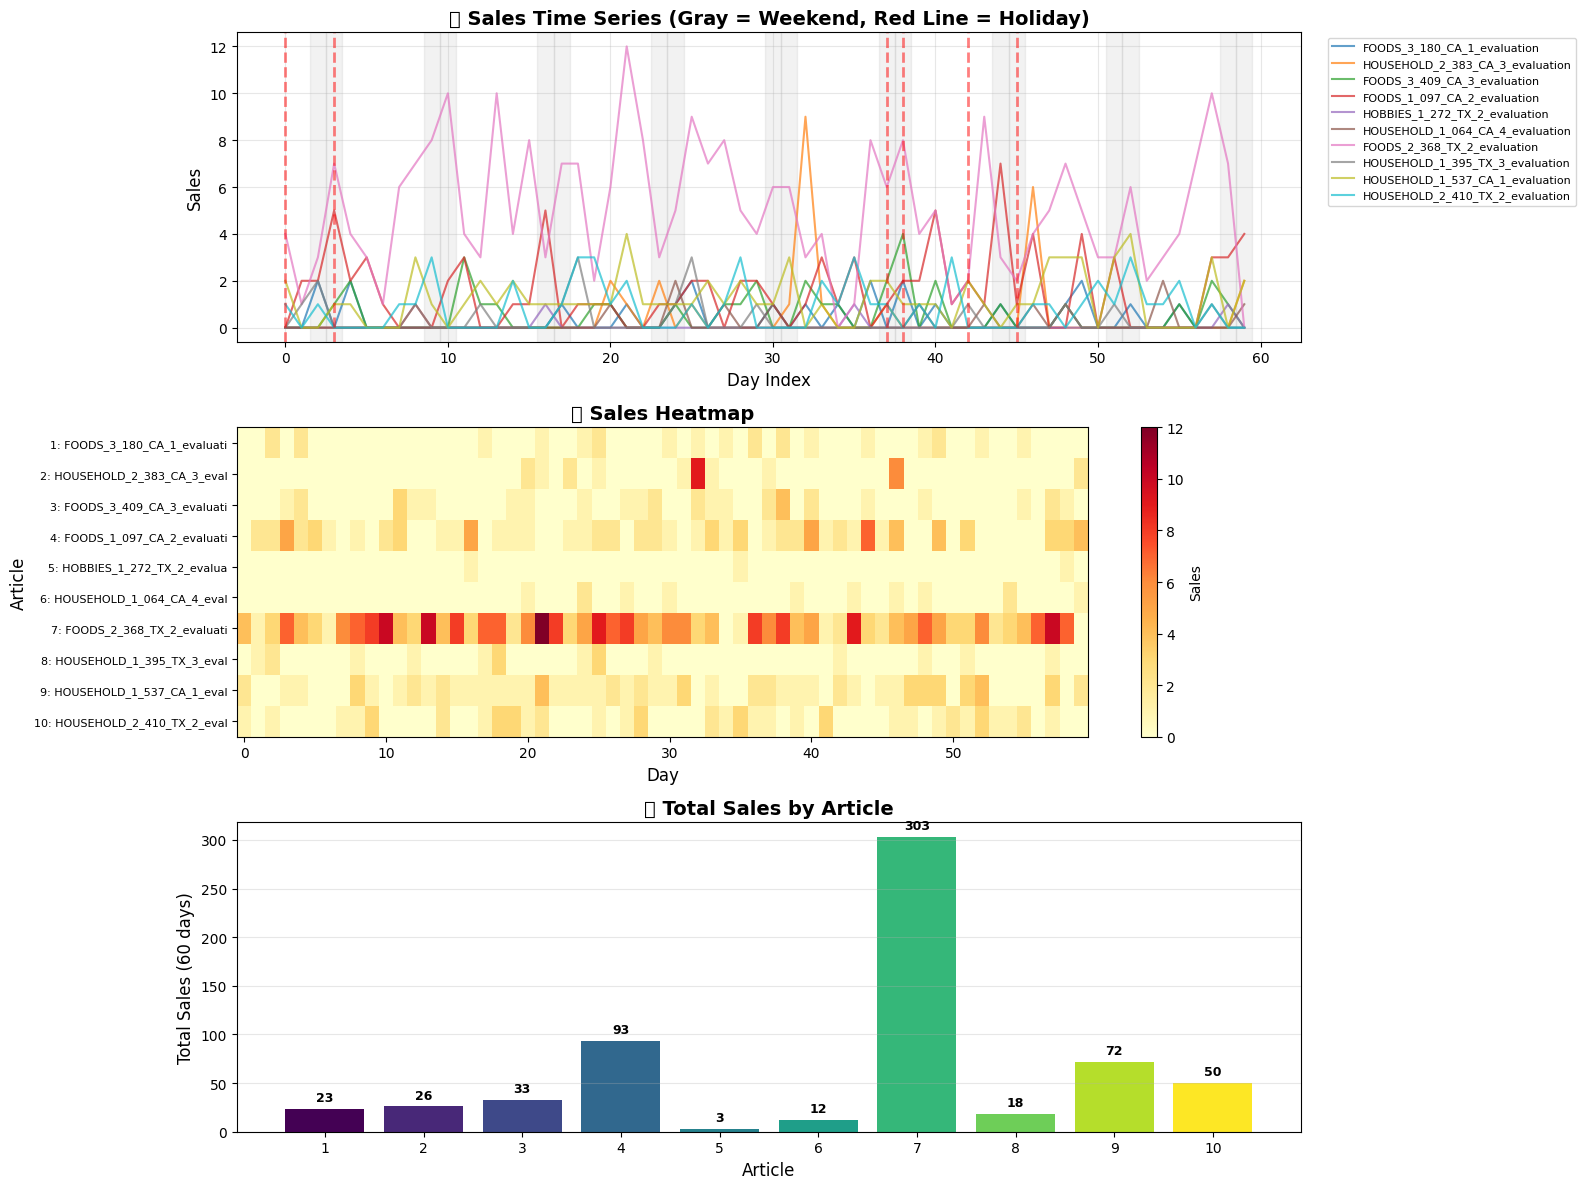

✅ Visualization complete!


In [10]:
# Extract article columns (exclude calendar columns)
article_cols = [col for col in final_df.columns if col not in ['date', 'weekday', 'is_weekend', 'is_holiday', 'event_name', 'event_type']]

# Visualizations
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Time series plot for all articles
ax = axes[0]
for col in article_cols:
    ax.plot(range(N_DAYS), final_df[col].values, alpha=0.7, linewidth=1.5, label=col[:35])

# Highlight weekends
for i in range(N_DAYS):
    if final_df.iloc[i]['is_weekend'] == 1:
        ax.axvspan(i-0.5, i+0.5, alpha=0.1, color='gray')

# Highlight holidays
for i in range(N_DAYS):
    if final_df.iloc[i]['is_holiday'] == 1:
        ax.axvline(x=i, color='red', linestyle='--', alpha=0.5, linewidth=2)

ax.set_xlabel('Day Index', fontsize=12)
ax.set_ylabel('Sales', fontsize=12)
ax.set_title('📊 Sales Time Series (Gray = Weekend, Red Line = Holiday)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# 2. Heatmap of sales
ax = axes[1]
sales_matrix = final_df[article_cols].T.values
im = ax.imshow(sales_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Article', fontsize=12)
ax.set_title('🔥 Sales Heatmap', fontsize=14, fontweight='bold')
ax.set_yticks(range(len(article_cols)))
ax.set_yticklabels([f"{i+1}: {col[:25]}" for i, col in enumerate(article_cols)], fontsize=8)
plt.colorbar(im, ax=ax, label='Sales')

# 3. Total sales per article
ax = axes[2]
total_sales = final_df[article_cols].sum()
colors = plt.cm.viridis(np.linspace(0, 1, N_ITEMS))
bars = ax.bar(range(N_ITEMS), total_sales.values, color=colors)
ax.set_xlabel('Article', fontsize=12)
ax.set_ylabel('Total Sales (60 days)', fontsize=12)
ax.set_title('📦 Total Sales by Article', fontsize=14, fontweight='bold')
ax.set_xticks(range(N_ITEMS))
ax.set_xticklabels([f"{i+1}" for i in range(N_ITEMS)], fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

for i, (bar, val) in enumerate(zip(bars, total_sales.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{val:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

## 🔧 Step 5: Preprocessing for Deep Learning

In [11]:
# Extract sales matrix (days × articles)
sales_matrix = final_df[article_cols].values  # Shape: (60, 10)

print(f"📊 Sales Matrix: {sales_matrix.shape} (days × articles)\n")

# Log transformation + normalization per article
sales_log = np.log1p(sales_matrix)
scalers = {}
sales_normalized = np.zeros_like(sales_log)

for i in range(sales_matrix.shape[1]):  # For each article
    scaler = MinMaxScaler(feature_range=(0, 1))
    sales_normalized[:, i] = scaler.fit_transform(sales_log[:, i].reshape(-1, 1)).flatten()
    scalers[article_cols[i]] = scaler

print("✅ Preprocessing:")
print(f"   • Log transformation: log1p(x)")
print(f"   • Normalization: MinMaxScaler [0, 1] per article")
print(f"   • {len(scalers)} scalers saved\n")

# Create sequences for each article
def create_sequences_per_article(data, window_size, horizon):
    """
    Create sliding window sequences for each article separately
    data: (n_days, n_articles)
    """
    X, y = [], []
    n_days, n_articles = data.shape
    
    for article_idx in range(n_articles):
        series = data[:, article_idx]
        
        for i in range(len(series) - window_size - horizon + 1):
            X.append(series[i:i+window_size])
            y.append(series[i+window_size:i+window_size+horizon])
    
    return np.array(X), np.array(y)

X, y = create_sequences_per_article(sales_normalized, WINDOW_SIZE, HORIZON)

print(f"🪟 Sequences Created:")
print(f"   Window: {WINDOW_SIZE} days → Forecast: {HORIZON} days")
print(f"   X shape: {X.shape} (samples, window_size)")
print(f"   y shape: {y.shape} (samples, horizon)")
print(f"   Total samples: {len(X)}\n")

# Temporal split
n_samples = len(X)
train_end = int(n_samples * 0.70)
val_end = int(n_samples * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"✂️ Temporal Split:")
print(f"   Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Val:   {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)\n")

# Reshape for RNN models
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_rnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"🔄 Data Shapes:")
print(f"   RNN format (3D): {X_train_rnn.shape}")
print(f"   MLP format (2D): {X_train.shape}")

📊 Sales Matrix: (60, 10) (days × articles)

✅ Preprocessing:
   • Log transformation: log1p(x)
   • Normalization: MinMaxScaler [0, 1] per article
   • 10 scalers saved

🪟 Sequences Created:
   Window: 14 days → Forecast: 28 days
   X shape: (190, 14) (samples, window_size)
   y shape: (190, 28) (samples, horizon)
   Total samples: 190

✂️ Temporal Split:
   Train: 133 samples (70.0%)
   Val:   28 samples (14.7%)
   Test:  29 samples (15.3%)

🔄 Data Shapes:
   RNN format (3D): (133, 14, 1)
   MLP format (2D): (133, 14)


## 🤖 Step 6: Train Models (LSTM, RNN, GRU, MLP)

In [14]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=0)

models = {}
histories = {}

print("🚀 TRAINING MODELS...")
print("="*80 + "\n")

# 1. LSTM
print("🧠 Training LSTM...")
model_lstm = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(HORIZON)
])
model_lstm.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
history_lstm = model_lstm.fit(X_train_rnn, y_train, validation_data=(X_val_rnn, y_val),
                                epochs=EPOCHS, batch_size=BATCH_SIZE, 
                                callbacks=[early_stop, reduce_lr], verbose=0)
models['LSTM'] = model_lstm
histories['LSTM'] = history_lstm
print(f"✅ LSTM: {len(history_lstm.history['loss'])} epochs, val_loss={history_lstm.history['val_loss'][-1]:.6f}\n")

# 2. GRU
print("🔄 Training GRU...")
model_gru = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(HORIZON)
])
model_gru.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
history_gru = model_gru.fit(X_train_rnn, y_train, validation_data=(X_val_rnn, y_val),
                              epochs=EPOCHS, batch_size=BATCH_SIZE,
                              callbacks=[early_stop, reduce_lr], verbose=0)
models['GRU'] = model_gru
histories['GRU'] = history_gru
print(f"✅ GRU: {len(history_gru.history['loss'])} epochs, val_loss={history_gru.history['val_loss'][-1]:.6f}\n")

# 3. RNN
print("🔁 Training Simple RNN...")
model_rnn = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(HORIZON)
])
model_rnn.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
history_rnn = model_rnn.fit(X_train_rnn, y_train, validation_data=(X_val_rnn, y_val),
                              epochs=EPOCHS, batch_size=BATCH_SIZE,
                              callbacks=[early_stop, reduce_lr], verbose=0)
models['RNN'] = model_rnn
histories['RNN'] = history_rnn
print(f"✅ RNN: {len(history_rnn.history['loss'])} epochs, val_loss={history_rnn.history['val_loss'][-1]:.6f}\n")

# 4. MLP
print("🎯 Training MLP...")
model_mlp = Sequential([
    Input(shape=(WINDOW_SIZE,)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(HORIZON)
])
model_mlp.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
history_mlp = model_mlp.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=EPOCHS, batch_size=BATCH_SIZE,
                              callbacks=[early_stop, reduce_lr], verbose=0)
models['MLP'] = model_mlp
histories['MLP'] = history_mlp
print(f"✅ MLP: {len(history_mlp.history['loss'])} epochs, val_loss={history_mlp.history['val_loss'][-1]:.6f}\n")

print("="*80)
print("🎉 ALL MODELS TRAINED!")
print("="*80)

🚀 TRAINING MODELS...

🧠 Training LSTM...
✅ LSTM: 43 epochs, val_loss=0.073367

🔄 Training GRU...
✅ LSTM: 43 epochs, val_loss=0.073367

🔄 Training GRU...
✅ GRU: 20 epochs, val_loss=0.075777

🔁 Training Simple RNN...
✅ GRU: 20 epochs, val_loss=0.075777

🔁 Training Simple RNN...
✅ RNN: 20 epochs, val_loss=0.080639

🎯 Training MLP...
✅ RNN: 20 epochs, val_loss=0.080639

🎯 Training MLP...
✅ MLP: 20 epochs, val_loss=0.075795

🎉 ALL MODELS TRAINED!
✅ MLP: 20 epochs, val_loss=0.075795

🎉 ALL MODELS TRAINED!


## 📊 Step 7: Evaluate Models & Compare Metrics

In [13]:
# Evaluate on test set
results = {}

for name, model in models.items():
    print(f"📊 Evaluating {name}...")
    
    # Use appropriate input format
    X_test_input = X_test_rnn if name != 'MLP' else X_test
    
    # Predictions
    y_pred = model.predict(X_test_input, verbose=0)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test.flatten(), y_pred.flatten())
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'predictions': y_pred
    }
    
    print(f"   RMSE: {rmse:.6f} | MAE: {mae:.6f} | R²: {r2:.6f}\n")

# Comparison table
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'MAE': [results[m]['MAE'] for m in results],
    'R²': [results[m]['R²'] for m in results]
}).sort_values('RMSE')

print("\n" + "="*80)
print("🏆 MODEL COMPARISON (sorted by RMSE - lower is better)")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)

best_model = comparison.iloc[0]
print(f"\n🥇 BEST MODEL: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.6f}")
print(f"   MAE:  {best_model['MAE']:.6f}")
print(f"   R²:   {best_model['R²']:.6f}")
print("="*80)

📊 Evaluating LSTM...
   RMSE: 0.362901 | MAE: 0.312975 | R²: -0.035282

📊 Evaluating GRU...
   RMSE: 0.362901 | MAE: 0.312975 | R²: -0.035282

📊 Evaluating GRU...
   RMSE: 0.482649 | MAE: 0.379493 | R²: -0.831243

📊 Evaluating RNN...
   RMSE: 0.474256 | MAE: 0.380638 | R²: -0.768107

📊 Evaluating MLP...
   RMSE: 0.482649 | MAE: 0.379493 | R²: -0.831243

📊 Evaluating RNN...
   RMSE: 0.474256 | MAE: 0.380638 | R²: -0.768107

📊 Evaluating MLP...
   RMSE: 0.500729 | MAE: 0.390484 | R²: -0.971006


🏆 MODEL COMPARISON (sorted by RMSE - lower is better)
Model      MSE     RMSE      MAE        R²
 LSTM 0.131697 0.362901 0.312975 -0.035282
  RNN 0.224919 0.474256 0.380638 -0.768107
  GRU 0.232950 0.482649 0.379493 -0.831243
  MLP 0.250729 0.500729 0.390484 -0.971006

🥇 BEST MODEL: LSTM
   RMSE: 0.362901
   MAE:  0.312975
   R²:   -0.035282
   RMSE: 0.500729 | MAE: 0.390484 | R²: -0.971006


🏆 MODEL COMPARISON (sorted by RMSE - lower is better)
Model      MSE     RMSE      MAE        R²
 LSTM 0.

## 📈 Step 8: Visualizations

In [ ]:
# 1. Training History
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📚 Training History: Loss Curves', fontsize=16, fontweight='bold')

for idx, (name, history) in enumerate(histories.items()):
    ax = axes[idx // 2, idx % 2]
    epochs = range(1, len(history.history['loss']) + 1)
    
    ax.plot(epochs, history.history['loss'], label='Train Loss', linewidth=2)
    ax.plot(epochs, history.history['val_loss'], label='Val Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss (MSE)', fontsize=11)
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training curves displayed")

In [ ]:
# 2. Model Comparison Bar Charts
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('📊 Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'MAE', 'R²']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = comparison[metric].values
    models_ordered = comparison['Model'].values
    
    bars = ax.bar(range(len(models_ordered)), values, color=colors[idx], alpha=0.8, edgecolor='black')
    ax.set_xticks(range(len(models_ordered)))
    ax.set_xticklabels(models_ordered, fontsize=11, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Comparison charts displayed")

In [ ]:
# 3. Sample Predictions vs Actual
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('🎯 Sample Predictions: Actual vs Predicted (Test Set)', fontsize=16, fontweight='bold')

sample_indices = [0, 5, 10, 15]  # Show 4 different test samples

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx // 2, idx % 2]
    
    sample_idx = sample_indices[idx] if idx < len(sample_indices) else 0
    
    if sample_idx < len(y_test):
        actual = y_test[sample_idx]
        predicted = results[name]['predictions'][sample_idx]
        
        x_axis = range(1, HORIZON + 1)
        ax.plot(x_axis, actual, 'o-', label='Actual', linewidth=2, markersize=8, color='blue')
        ax.plot(x_axis, predicted, 's--', label='Predicted', linewidth=2, markersize=8, color='red', alpha=0.7)
        
        ax.set_xlabel('Forecast Day', fontsize=11)
        ax.set_ylabel('Sales (Normalized)', fontsize=11)
        ax.set_title(f'{name} - Sample {sample_idx+1}', fontsize=13, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xticks(x_axis)

plt.tight_layout()
plt.show()

print("✅ Prediction samples displayed")

## 📝 Step 9: Generate Submission Format (like sample_submission.csv)

In [ ]:
# Load sample submission to understand format
sample_sub = pd.read_csv('sample_submission.csv')

print("📋 Sample Submission Format:")
print(f"   Shape: {sample_sub.shape}")
print(f"   Columns: {sample_sub.columns.tolist()[:10]} ...\n")
print(sample_sub.head())

print("\n" + "="*80)
print("🔮 GENERATING PREDICTIONS FOR BEST MODEL")
print("="*80)

# Use best model for final predictions
best_model_name = comparison.iloc[0]['Model']
best_model_obj = models[best_model_name]

print(f"\n✅ Best Model: {best_model_name}")
print(f"   RMSE: {comparison.iloc[0]['RMSE']:.6f}")
print(f"   MAE:  {comparison.iloc[0]['MAE']:.6f}")
print(f"   R²:   {comparison.iloc[0]['R²']:.6f}\n")

# Create predictions for all articles
# For each article, use the last WINDOW_SIZE days to predict next HORIZON days
predictions_dict = {}

for i, article_id in enumerate(article_cols):
    # Get last WINDOW_SIZE days for this article
    last_sequence = sales_normalized[-(WINDOW_SIZE):, i].reshape(1, WINDOW_SIZE)
    
    if best_model_name == 'MLP':
        pred = best_model_obj.predict(last_sequence, verbose=0)
    else:
        last_sequence_3d = last_sequence.reshape(1, WINDOW_SIZE, 1)
        pred = best_model_obj.predict(last_sequence_3d, verbose=0)
    
    # Inverse transform
    scaler = scalers[article_id]
    pred_original = np.expm1(scaler.inverse_transform(pred.reshape(-1, 1)).flatten())
    
    predictions_dict[article_id] = pred_original

# Create submission dataframe
submission_data = []
for article_id in article_cols:
    row_data = {'id': article_id}
    for day_idx in range(HORIZON):
        col_name = f'F{day_idx + 1}'
        row_data[col_name] = predictions_dict[article_id][day_idx]
    submission_data.append(row_data)

submission_df = pd.DataFrame(submission_data)

print("📊 SUBMISSION FORMAT PREDICTIONS:")
print("="*80)
print(f"Shape: {submission_df.shape}")
print(f"\nFirst few predictions:\n")
print(submission_df.head(10))
print("="*80)

# Save to file
submission_df.to_csv('my_submission.csv', index=False)
print(f"\n✅ Predictions saved to: my_submission.csv")

print("\n" + "="*80)
print("🎉 PIPELINE COMPLETE!")
print("="*80)
print(f"\n📊 Summary:")
print(f"   • Data structure: Days as rows, Articles as columns")
print(f"   • Calendar info included: Holidays, weekends, events")
print(f"   • Models trained: LSTM, GRU, RNN, MLP")
print(f"   • Best model: {best_model_name}")
print(f"   • Submission file: my_submission.csv (sample_submission format)")
print("="*80)